In [ ]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.8.0+cu126
torchvision version: 0.23.0+cu126


In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Total 4393 (delta 0), reused 0 (delta 0), pack-reused 4393 (from 1)
Receiving objects: 100% (4393/4393), 764.14 MiB | 16.90 MiB/s, done.
Resolving deltas: 100% (2657/2657), done.
Updating files: 100% (248/248), done.


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [ ]:
train_dir = image_path / "train"
test_dir = image_path / "test"

In [ ]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [ ]:
from going_modular.going_modular import data_setup
from torchvision import transforms

IMG_SIZE = 224

#create transforms
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

manual_transforms

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

In [ ]:
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = manual_transforms,
    batch_size = BATCH_SIZE
)
len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

In [ ]:
image_batch, label_batch = next(iter(train_dataloader))
image, label = image_batch[0], label_batch[0]

Text(0.5, 1.0, 'pizza')

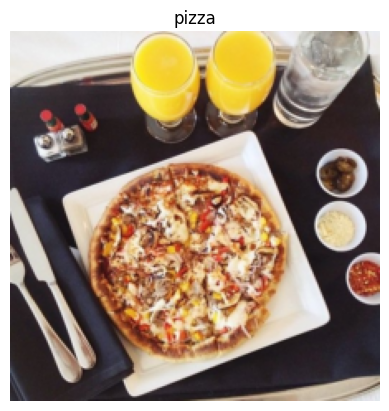

In [ ]:
import matplotlib
from matplotlib import pyplot as plt

plt.imshow(image.permute(1,2,0))
plt.axis(False)
plt.title(class_names[label])

In [ ]:
#split data into classes
height = 224
width = 224
color_channels = 3
patch_size = 16

number_of_patches = int((height * width) / patch_size**2)
number_of_patches

196

In [ ]:
#input shape
embedding_layer_input_shape = (height, width, color_channels)

#output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

In [ ]:
image.shape

torch.Size([3, 224, 224])

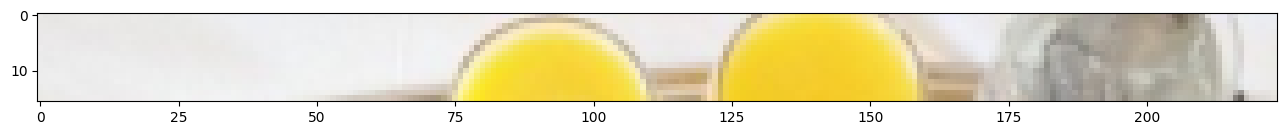

In [ ]:
image_permuted = image.permute(1,2,0)

#index to plot the top row of pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, : , :])

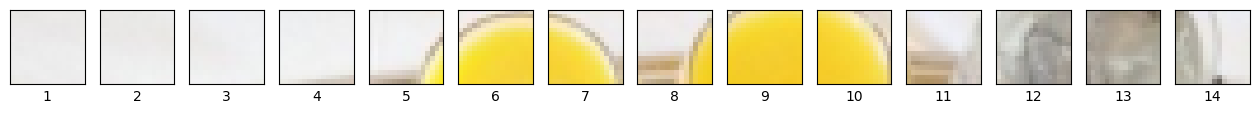

In [ ]:
#setup code to plot top roaw as patches
img_size = 224
path_size = 16
num_patches = img_size/ patch_size
assert img_size % patch_size == 0,"Image size must be divisible by patch size"

#create a series of subplot
figs, axs = plt.subplots(nrows =1,
                        ncols = img_size // patch_size,
                        sharex=True,
                        sharey=True,
                        figsize = (patch_size, patch_size))

for i,patch in enumerate(range(0, img_size, patch_size)):
  axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :])
  axs[i].set_xlabel(i+1)
  axs[i].set_xticks([])
  axs[i].set_yticks([])


In [ ]:
# img_size = 224
# patch_size = 16
# num_patches = img_size/patch_size
# assert img_size % patch_size == 0, "Image size must be divisble by patch size"
# print(f"Number of patches per row: {num_patches}\
# \nNumber of patches per column: {num_patches}\
# \nTotal patches : {num_patches * num_patches}\
# \nPatch size: {patch_size} pixels X {patch_size} pixels")

# fig, axs = plt.subplots(nrows=img_size // patch_size,
#                         ncols=img_size // patch_size,
#                         figsize=(num_patches, num_patches),
#                         sharex=True,
#                         sharey=True)

# for i, patch_height in enumerate(range(0, img_size, patch_size)):
#   for j, patch_width in enumerate(range(0, img_size, patch_size)):


In [ ]:
from torch import nn

patch_size = 16

conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)

conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

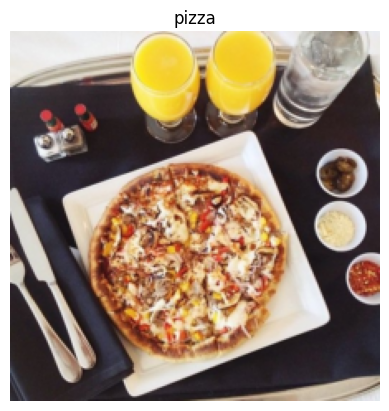

In [ ]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

In [ ]:
image_out_of_conv = conv2d(image.unsqueeze(0))
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


In [ ]:
image_out_of_conv.requires_grad

True

In [ ]:
import random
random_indexes = random.sample(range(0, 758), k=5)
print(f"showing random convolutional feature maps from indexes : {random_indexes}")



showing random convolutional feature maps from indexes : [216, 659, 457, 626, 345]


In [ ]:
from torch import nn
flatten_layer = nn.Flatten(start_dim=2, end_dim=3)
flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

In [ ]:
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)


In [ ]:
image_out_of_conv_flattened_permuted = image_out_of_conv_flattened.permute(0,2,1)

Text(0.5, 1.0, 'Flattened feature map shape: tensor([[ 9.6170e-02,  9.9394e-02,  1.0597e-01,  8.8178e-02,  2.7818e-02,\n          4.0150e-02,  6.4856e-02, -2.2838e-02, -4.7926e-02, -5.1024e-02,\n          1.0030e-01,  1.8178e-02,  9.8222e-02,  2.1070e-01, -8.5834e-05,\n          5.7300e-03,  1.2315e-01, -1.2328e-01,  1.3217e-01, -9.9825e-02,\n         -2.9535e-02,  1.0420e-01, -1.3129e-01, -1.3225e-01,  1.0722e-01,\n          3.5548e-02, -7.0145e-02,  3.0200e-02,  4.8618e-02,  6.8998e-02,\n         -5.7194e-02,  2.9912e-02,  1.3535e-02, -6.8878e-02, -1.4246e-01,\n          4.6912e-02, -3.7013e-02, -2.1114e-01,  5.7619e-02,  3.5377e-02,\n         -5.0696e-02,  1.2559e-01,  2.7348e-02,  1.6854e-02, -1.9406e-02,\n         -3.8299e-02,  1.0207e-02, -6.4173e-02, -1.7065e-01,  5.1195e-02,\n          2.8141e-03,  9.3245e-03, -1.0571e-01, -1.4077e-02,  1.0397e-02,\n          2.3247e-02, -1.1158e-02, -1.9124e-01, -1.9376e-01,  8.6363e-03,\n          2.5963e-02,  1.7175e-01,  3.4855e-01,  1.2452

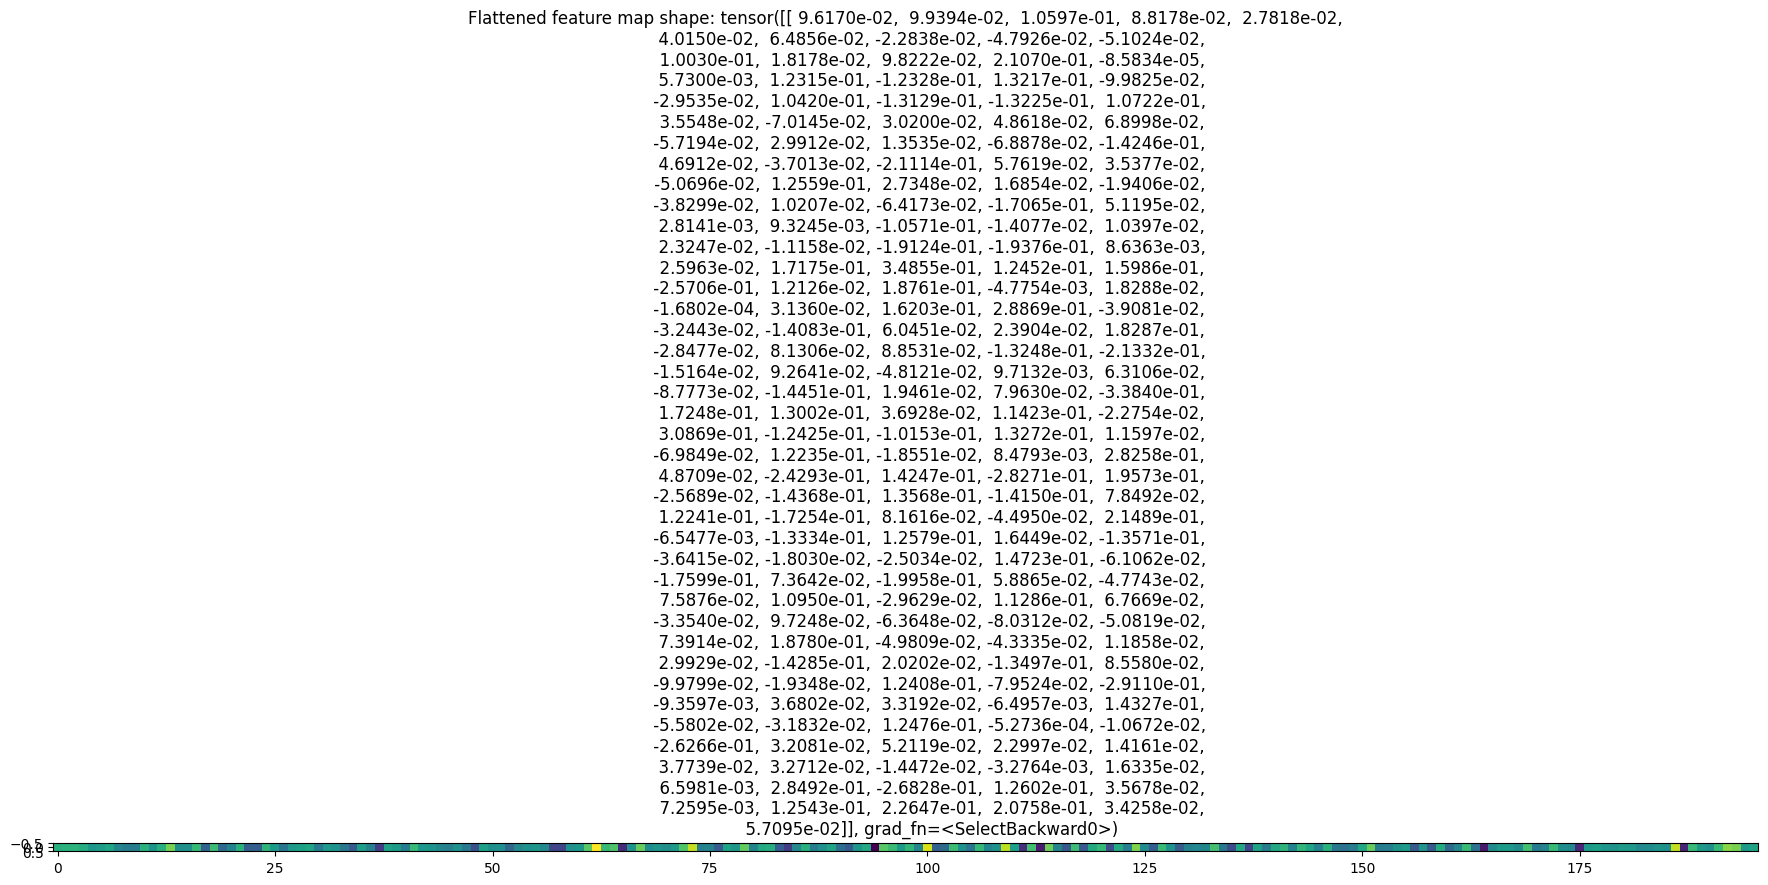

In [ ]:
single_flattened_feature_map = image_out_of_conv_flattened_permuted[:, : , 0]
single_flattened_feature_map
plt.figure(figsize=(22,22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map}")


In [ ]:
class PatchEmbedding(nn.Module):
  def __init__(self,
             in_channels:int=3,
             patch_size:int=16,
             embedding_dimension:int=768 ):
    super().__init__()
    self.patch_size = patch_size
    self.patcher = nn.Conv2d(in_channels=in_channels,
                             out_channels=embedding_dimension,
                             kernel_size = patch_size,
                             stride=patch_size,
                             padding=0)
    self.flatten = nn.Flatten(start_dim=2, end_dim=3)

  def forward(self, x):
    image_resolution=x.shape[-1]
    assert image_resolution % patch_size ==0, f"Image size must be divisible by patch size, Image shape: {image_resolution}, patch size : {self.patch_size}"
    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)

    return x_flattened.permute(0, 2, 1)

In [ ]:
set_seeds()
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dimension=768)

print(f"Input image size: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0))
print(f"Output patch embedding sequence shape: {patch_embedded_image.shape}")

Input image size: torch.Size([1, 3, 224, 224])
Output patch embedding sequence shape: torch.Size([1, 196, 768])


#Creating the class token embedding
Want to : prepend a learnable class token to the start of the patch embedding

In [ ]:
patch_embedded_image

tensor([[[-0.9559,  0.2557, -0.2788,  ...,  0.7270, -0.4252,  0.3416],
         [-0.9550,  0.2627, -0.2936,  ...,  0.7346, -0.4259,  0.3391],
         [-0.9767,  0.2694, -0.2797,  ...,  0.7473, -0.4352,  0.3414],
         ...,
         [-0.5510,  0.0263, -0.4428,  ...,  0.4074, -0.0395,  0.4125],
         [-0.7707,  0.2181, -0.2003,  ...,  0.2947, -0.0903,  0.3046],
         [-0.7969,  0.2857, -0.3141,  ...,  0.5529, -0.2730,  0.2207]]],
       grad_fn=<PermuteBackward0>)

In [ ]:
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size, embedding_dimension

(1, 768)

In [ ]:
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), requires_grad=True)
class_token.shape

torch.Size([1, 1, 768])

In [ ]:
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image), dim=1)

print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape : {patch_embedded_image_with_class_embedding.shape}")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.9559,  0.2557, -0.2788,  ...,  0.7270, -0.4252,  0.3416],
         [-0.9550,  0.2627, -0.2936,  ...,  0.7346, -0.4259,  0.3391],
         ...,
         [-0.5510,  0.0263, -0.4428,  ...,  0.4074, -0.0395,  0.4125],
         [-0.7707,  0.2181, -0.2003,  ...,  0.2947, -0.0903,  0.3046],
         [-0.7969,  0.2857, -0.3141,  ...,  0.5529, -0.2730,  0.2207]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape : torch.Size([1, 197, 768])


In [ ]:
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.9559,  0.2557, -0.2788,  ...,  0.7270, -0.4252,  0.3416],
          [-0.9550,  0.2627, -0.2936,  ...,  0.7346, -0.4259,  0.3391],
          ...,
          [-0.5510,  0.0263, -0.4428,  ...,  0.4074, -0.0395,  0.4125],
          [-0.7707,  0.2181, -0.2003,  ...,  0.2947, -0.0903,  0.3046],
          [-0.7969,  0.2857, -0.3141,  ...,  0.5529, -0.2730,  0.2207]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [ ]:
number_of_patches = int((height * width) / patch_size ** 2)
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True)
position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [ ]:
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch and position embedding shape : {patch_and_position_embedding.shape}")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.0441, 1.2557, 0.7212,  ..., 1.7270, 0.5748, 1.3416],
         [0.0450, 1.2627, 0.7064,  ..., 1.7346, 0.5741, 1.3391],
         ...,
         [0.4490, 1.0263, 0.5572,  ..., 1.4074, 0.9605, 1.4125],
         [0.2293, 1.2181, 0.7997,  ..., 1.2947, 0.9097, 1.3046],
         [0.2031, 1.2857, 0.6859,  ..., 1.5529, 0.7270, 1.2207]]],
       grad_fn=<AddBackward0>)
Patch and position embedding shape : torch.Size([1, 197, 768])


In [ ]:
patch_size = 16
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

x = image.unsqueeze(0)
print(f"Input image shape: {x.shape}")

patch_embedding_layer = PatchEmbedding(in_channels=3,
                                      patch_size=patch_size,
                                      embedding_dimension=768)

patch_embedding = patch_embedding_layer(x)
print(f"Patch embedding shape: {patch_embedding.shape}")

batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), requires_grad=True)
print(f"Class token embeding shape: {class_token.shape}")

patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

number_of_patches = int((height * width)  / patch_size ** 2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension), requires_grad=True)

patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")


Image tensor shape: torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
Class token embeding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


In [ ]:
class MultiHeadSelfAttentionBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768,
               num_heads:int=12,
               attn_dropout:int=0):
    super().__init__()
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                num_heads=num_heads,
                                                dropout=attn_dropout,
                                                batch_first=True)
  def forward(self, x):
    x = self.layer_norm(x)
    attn_output, _ = self.multihead_attn(query=x,
                                      key=x,
                                      value=x,
                                      need_weights=False)
    return attn_output

In [ ]:
multihead_self_attention_block = MultiHeadSelfAttentionBlock(embedding_dim=768,
                                                            num_heads=12,
                                                            attn_dropout=0)
patch_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block : {patch_and_position_embedding.shape}")
print(f"Input shape of MSA block : {patch_image_through_msa_block.shape}")

Input shape of MSA block : torch.Size([1, 197, 768])
Input shape of MSA block : torch.Size([1, 197, 768])


In [ ]:
patch_image_through_msa_block.dtype


torch.float32

In [ ]:
class MLPBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768,
               mlp_size:int=3072,
               dropout:int=0.1):
    super().__init__()
    self.layernorm = nn.LayerNorm(normalized_shape=embedding_dim)
    self.mlp = nn.Sequential(
        nn.Linear(in_features=embedding_dim,
                  out_features=mlp_size),
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features = mlp_size,
                  out_features=embedding_dim),
        nn.Dropout(p=dropout)
    )

  def forward(self, x):
    x = self.layernorm(x)
    x = self.mlp(x)
    return x

In [ ]:
mlp_block = MLPBlock(embedding_dim=768,
                     mlp_size=3072,
                     dropout=0.1)
patched_image_through_mlp_block = mlp_block(patch_image_through_msa_block)


In [ ]:
patched_image_through_mlp_block

tensor([[[-4.9238e-04, -3.5739e-01, -2.9429e-04,  ..., -9.4028e-02,
           2.8257e-01, -8.4674e-02],
         [ 4.8566e-02, -2.3074e-01,  2.9485e-02,  ..., -3.5437e-02,
           1.0270e-01, -9.4218e-02],
         [-7.2246e-02, -0.0000e+00,  0.0000e+00,  ...,  1.2479e-01,
           2.6393e-01, -7.2785e-02],
         ...,
         [-1.4195e-01, -2.7115e-01,  1.5635e-01,  ..., -1.3806e-01,
           0.0000e+00, -2.2926e-01],
         [-7.1655e-02, -0.0000e+00,  1.0390e-01,  ..., -4.4922e-02,
           2.2917e-01, -7.9094e-02],
         [-1.6051e-01, -2.7435e-01, -0.0000e+00,  ..., -7.2466e-02,
           2.5064e-01, -0.0000e+00]]], grad_fn=<MulBackward0>)

In [ ]:
patch_image_through_msa_block


tensor([[[ 0.2330,  0.1477, -0.0842,  ..., -0.0548, -0.7364, -0.3128],
         [ 0.2304,  0.1661, -0.0953,  ..., -0.0581, -0.7389, -0.3064],
         [ 0.2306,  0.1661, -0.0953,  ..., -0.0580, -0.7390, -0.3064],
         ...,
         [ 0.2351,  0.1657, -0.0938,  ..., -0.0489, -0.7331, -0.3057],
         [ 0.2305,  0.1625, -0.0897,  ..., -0.0539, -0.7334, -0.3062],
         [ 0.2291,  0.1640, -0.0905,  ..., -0.0559, -0.7404, -0.3037]]],
       grad_fn=<TransposeBackward0>)

In [ ]:
class TransformerEncoderBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768,
               num_heads:int=12,
               mlp_size:int=3072,
               mlp_dropout:int=0.1,
               attn_dropout:int=0):
    super().__init__()
    self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                 num_heads=num_heads,
                                                 attn_dropout=attn_dropout)
    self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                              mlp_size=mlp_size,
                              dropout=mlp_dropout)

  def forward(self, x):
    x = self.msa_block(x) + x
    x = self.mlp_block(x) + x
    return x

In [ ]:
transformer_encoder_block = TransformerEncoderBlock()

summary(model=transformer_encoder_block,
        input_size = (1, 197, 768),
        col_names=["input_size","output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layernorm)                       [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

In [ ]:
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768,
                                                             nhead=12,
                                                             dim_feedforward=3072,
                                                             dropout=0.1,
                                                             activation="gelu",
                                                             batch_first=True,
                                                             norm_first=True)

torch_transformer_encoder_layer


TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [ ]:
class ViT(nn.Module):
  def __init__(self,
             img_size:int=224,
             in_channels:int=3,
             patch_size:int=16,
             num_transformer_layers:int=12,
             embedding_dim:int=768,
             mlp_size:int=3072,
             num_heads:int=12,
             attn_dropout:int=0,
             mlp_dropout:int=0.1,
             embedding_dropout:int=0.1,
             num_classes:int=1000):
    super().__init__()

    assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image: {img_size}, patch_size : {patch_size}"

    self.num_patches = (img_size * img_size // patch_size ** 2)

    self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                        requires_grad=True)

    self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim))

    self.embedding_dropout = nn.Dropout(p=embedding_dropout)

    self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                          patch_size=patch_size,
                                          embedding_dimension=embedding_dim)

    self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                       num_heads=num_heads,
                                                                       mlp_size=mlp_size,
                                                                       mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
    )

  def forward(self, x):
    batch_size = x.shape[0]
    class_token = self.class_embedding.expand(batch_size, -1, -1)
    x = self.patch_embedding(x)
    x = torch.cat((class_token, x), dim=1)
    x = self.position_embedding + x
    x = self.embedding_dropout(x)
    x = self.transformer_encoder(x)
    x = self.classifier(x[:,0])
    return x


In [ ]:
vit = ViT()
vit

ViT(
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (patch_embedding): PatchEmbedding(
    (patcher): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (flatten): Flatten(start_dim=2, end_dim=3)
  )
  (transformer_encoder): Sequential(
    (0): TransformerEncoderBlock(
      (msa_block): MultiHeadSelfAttentionBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
      )
      (mlp_block): MLPBlock(
        (layernorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
   

In [ ]:
random_image_tensor = torch.randn(1, 3, 224, 224)

vit = ViT(num_classes=len(class_names))
vit(random_image_tensor)

tensor([[ 0.1487,  0.1364, -0.2775]], grad_fn=<AddmmBackward0>)

In [ ]:
from going_modular.going_modular import engine
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = vit.parameters(),
                             lr=0.001,
                             betas=(0.9,0.999),
                             weight_decay=0.1)
results = engine.train(model=vit,
                       train_dataloader = train_dataloader,
                       test_dataloader=test_dataloader,
                       epochs=10,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.1035 | train_acc: 0.4102 | test_loss: 1.4441 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.5273 | train_acc: 0.2773 | test_loss: 1.6289 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.5805 | train_acc: 0.2812 | test_loss: 1.2632 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.4011 | train_acc: 0.2773 | test_loss: 1.7211 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.2303 | train_acc: 0.3125 | test_loss: 1.0272 | test_acc: 0.5417
Epoch: 6 | train_loss: 1.1453 | train_acc: 0.4023 | test_loss: 1.5822 | test_acc: 0.2604
Epoch: 7 | train_loss: 1.2837 | train_acc: 0.2930 | test_loss: 1.0503 | test_acc: 0.5417
Epoch: 8 | train_loss: 1.2677 | train_acc: 0.2656 | test_loss: 1.8500 | test_acc: 0.1979
Epoch: 9 | train_loss: 1.3055 | train_acc: 0.2773 | test_loss: 1.0123 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.1827 | train_acc: 0.2734 | test_loss: 1.5205 | test_acc: 0.2604


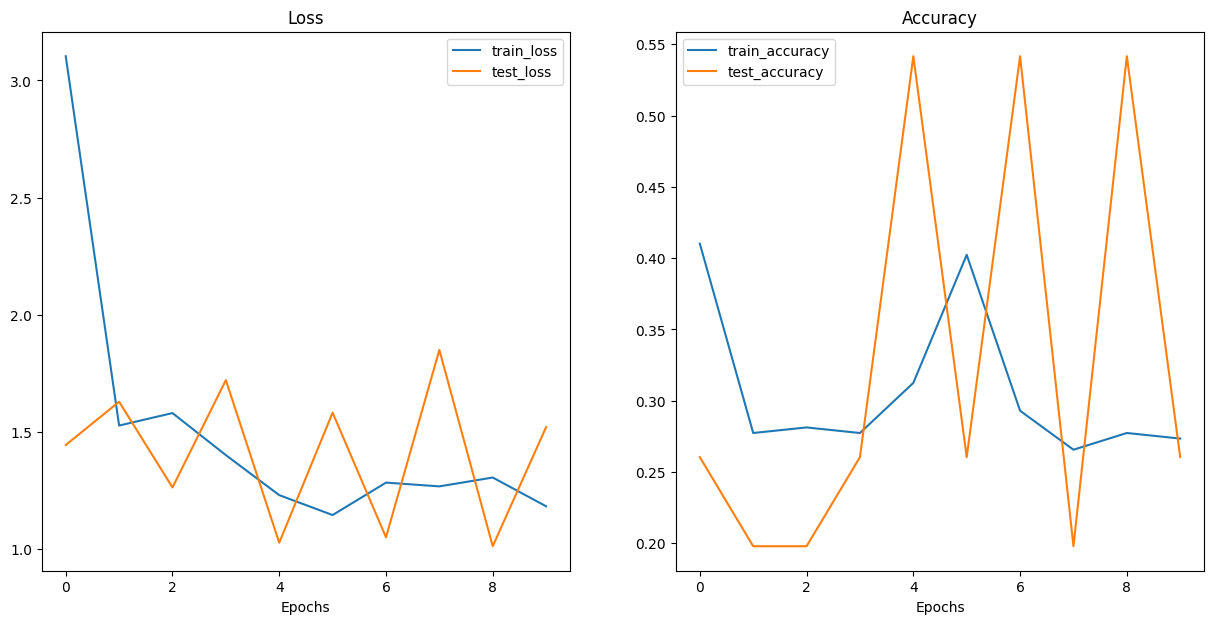

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

In [ ]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights)

for parameter in pretrained_vit.parameters():
  parameter.requires_grad=False

pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

In [ ]:
auto_transforms = pretrained_vit_weights.transforms()

In [ ]:
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir = test_dir,
                                                                                                     transform = auto_transforms,
                                                                                                     batch_size=32)

In [ ]:
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader = test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8534 | train_acc: 0.6953 | test_loss: 0.5446 | test_acc: 0.8475
Epoch: 2 | train_loss: 0.3562 | train_acc: 0.9531 | test_loss: 0.3056 | test_acc: 0.9375
Epoch: 3 | train_loss: 0.2350 | train_acc: 0.9531 | test_loss: 0.2457 | test_acc: 0.9176
Epoch: 4 | train_loss: 0.1768 | train_acc: 0.9609 | test_loss: 0.2292 | test_acc: 0.9280
Epoch: 5 | train_loss: 0.1579 | train_acc: 0.9648 | test_loss: 0.2255 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.2997 | train_acc: 0.8477 | test_loss: 0.2119 | test_acc: 0.9176
Epoch: 7 | train_loss: 0.1048 | train_acc: 0.9805 | test_loss: 0.2229 | test_acc: 0.8873
Epoch: 8 | train_loss: 0.1073 | train_acc: 0.9805 | test_loss: 0.2264 | test_acc: 0.9176
Epoch: 9 | train_loss: 0.0883 | train_acc: 0.9844 | test_loss: 0.2377 | test_acc: 0.8977
Epoch: 10 | train_loss: 0.0813 | train_acc: 0.9844 | test_loss: 0.2295 | test_acc: 0.8977


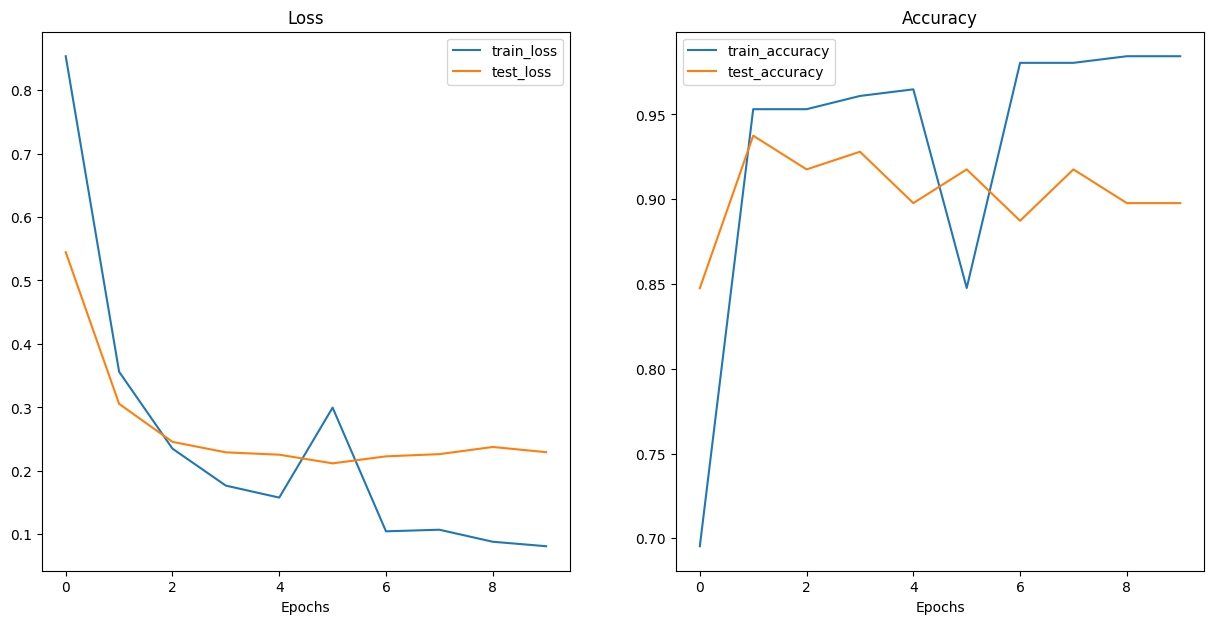

In [ ]:
plot_loss_curves(pretrained_vit_results)

In [ ]:
from going_modular.going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name = "08_pretrained_Vit_features_extractor__pizza_steak_sushi.pth")

[INFO] Saving model to: models/08_pretrained_Vit_features_extractor__pizza_steak_sushi.pth


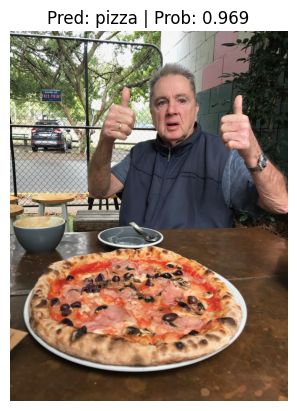

In [ ]:
import requests

# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = image_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)